In [1]:
import glob
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter

import torchvision.models as models

from torchsummary import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import xml.etree.ElementTree as ET

from copy import deepcopy

from sklearn.model_selection import train_test_split

In [2]:
# kaggle api를 사용할 수 있는 패키지 설치
!pip install kaggle

# kaggle.json upload
from google.colab import files
files.upload()

# permmision warning 방지
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset
# unzip(압축풀기)
!unzip -qq "/content/stanford-dogs-dataset.zip"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
 99% 744M/750M [00:04<00:00, 185MB/s]
100% 750M/750M [00:04<00:00, 170MB/s]


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
root_dir = '/content/'
img_dir = '/images/Images/'
annot_dir = '/annotations/Annotation/'

In [5]:
import os

labels_map = {}
for i, item in enumerate(os.listdir(root_dir + img_dir)):
    sub_folder = os.path.join(root_dir + img_dir, item)
    labels_map[sub_folder.split('-', maxsplit=1)[1]] = i

In [7]:
def img_crop(annot_path, img):
    tree = ET.parse(annot_path)
    obj = tree.find('./object')
    bndbox = obj.find('bndbox')

    # 강아지 종류
    species = obj.find('name').text

    # 이미지에서의 강아지 위치
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    cropped_img = img[ymin:ymax, xmin:xmax]
    
    label = labels_map.get(species)

    return label, cropped_img

In [22]:
class DogsDataset(Dataset):
    def __init__(self, annot_dir, img_dir, transform=None):
        annot_dir = glob.glob(root_dir + annot_dir + '*/*')
        img_dir = glob.glob(root_dir + img_dir + '*/*.jpg')
        self.annot_dir = sorted(annot_dir)
        self.img_dir = sorted(img_dir)
        self.transform = transform
        
    def __len__(self):
        return len(self.img_dir)
        
    def __getitem__(self, idx):
        annot_path = self.annot_dir[idx]
        img_path = self.img_dir[idx]
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label, img = img_crop(annot_path, img)
        if self.transform is not None:
            img = self.transform(image=img)
            img['label'] = label
            return img

        sample = {'image': img, 'label': label}
        return sample

In [23]:
transformer = A.Compose([
    A.Resize(224,224),
    A.Normalize(),
    ToTensorV2()
])

In [24]:
total_dataset = DogsDataset(annot_dir=annot_dir,
                           img_dir=img_dir, transform=transformer)

In [25]:
total_label = [data['label'] for data in total_dataset]

trainset_idx, testset_idx = train_test_split(range(len(total_dataset)),
                test_size=0.2, random_state=42, shuffle=True, stratify=total_label)

In [26]:
train_set_ = Subset(total_dataset, trainset_idx)

train_label = [data['label'] for data in train_set_]

trainset_idx, validset_idx = train_test_split(range(len(trainset_idx)),
                test_size=0.2, random_state=42, shuffle=True, stratify=train_label)

In [27]:
train_set = Subset(train_set_, trainset_idx)
test_set = Subset(total_dataset, testset_idx)
valid_set = Subset(train_set_, validset_idx)

# 시각화

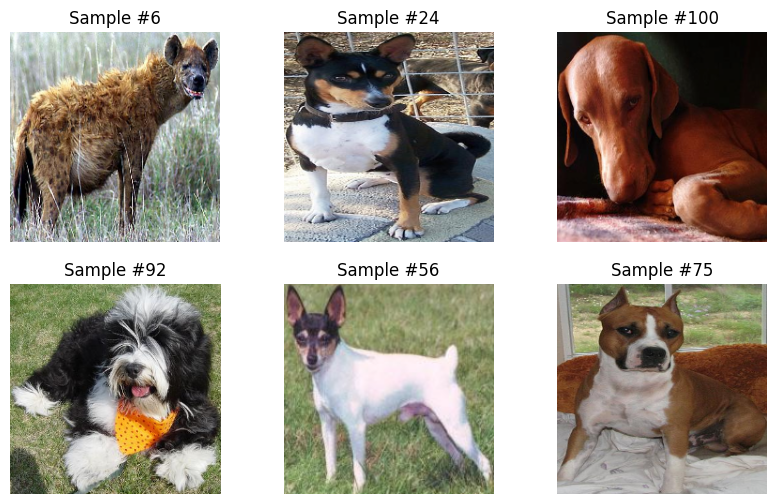

In [28]:
figure, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axes = axes.flatten()

for i in range(6):
    rand_i = np.random.randint(0, len(total_dataset))
    sample = total_dataset[rand_i]
    image = sample['image'].permute(1, 2, 0)
    label = sample['label']
    
    mean=torch.tensor([0.485, 0.456, 0.406]) 
    std=torch.tensor([0.229, 0.224, 0.225])
    image.mul_(std)
    image.add_(mean)
    
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title('Sample #{}'.format(label))

# 데이터 적재

In [29]:
batch_size = 16
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validloader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [30]:
train_iter = iter(trainloader)
batch = next(train_iter)
batch['image'].size(), len(batch['label'])

(torch.Size([16, 3, 224, 224]), 16)

# 모델 생성

In [31]:
model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:01<00:00, 99.1MB/s]


In [32]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 모델 변경

In [33]:
model.fc = nn.Linear(in_features=2048, out_features=120, bias=True)

In [34]:
for parameter in model.parameters():
    parameter.requires_grad = False

In [35]:
for parameter in model.fc.parameters():
    parameter.requires_grad=True

In [36]:
for parameter in model.parameters():
    print(parameter.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [37]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [38]:
out = model(batch['image'].to(device))
out.shape

torch.Size([16, 120])

In [39]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

In [40]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [41]:
def validate(model, validloader, loss_fn):
    total = 0   
    correct = 0
    valid_loss = 0
    valid_accuracy = 0

  
    with torch.no_grad():
        for batch in validloader:
            images=batch['image'].to(device)
            labels=batch['label']
            labels = torch.Tensor(labels).to(device)

            logit = model(images) 
            _, preds = torch.max(logit, 1)
            correct += int((preds == labels).sum())
            total += labels.shape[0]

            loss = loss_fn(logit, labels)
            valid_loss += loss.item()

        valid_accuracy = correct / total
  
    return valid_loss, valid_accuracy

In [42]:
writer = SummaryWriter()

In [43]:
def train_loop(model, trainloader, loss_fn, epochs, optimizer):
    steps = 0
    steps_per_epoch = len(trainloader)
    min_loss = np.inf
    max_accuracy = -np.inf
    trigger = 0
    p = 10


    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in trainloader:
            images=batch['image'].to(device)
            labels=batch['label']
            labels = torch.Tensor(labels).to(device)
            
            steps+=1
                      
            predict = model(images)
            loss = loss_fn(predict, labels)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            train_loss += loss.item()

            if (steps % steps_per_epoch) == 0:
                model.eval()
                valid_loss, valid_accuracy = validate(model, validloader, loss_fn)    
                
                print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
                    'Train Loss : {:.3f}'.format(train_loss/len(trainloader)), 
                    'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
                    'Valid Accuracy : {:.3f}'.format(valid_accuracy))

                if (valid_loss < min_loss) and (valid_accuracy >= max_accuracy):
                    print('save ckpt')
                    min_loss = valid_loss
                    max_accuracy = valid_accuracy

                    best_model = deepcopy(model)
                    torch.save(best_model.state_dict(), 'best_ckpt_transfer_res101_batch16_default')

                
                # --- early stopping --- #
                if valid_loss > min_loss:
                    print('----trigger----', trigger+1)
                    trigger += 1
                    if trigger > p:
                        print('Early Stopping')
                        print('training loop is finished')

                        return 
                else:
                    trigger = 0
                    min_loss = valid_loss
                    
                scheduler.step(valid_loss)
                    


In [44]:
epochs = 150
%time train_loop(model, trainloader, loss_fn, epochs, optimizer)

Epoch : 1/150....... Train Loss : 1.663 Valid Loss : 0.812 Valid Accuracy : 0.807
save ckpt
Epoch : 2/150....... Train Loss : 0.584 Valid Loss : 0.663 Valid Accuracy : 0.829
save ckpt
Epoch : 3/150....... Train Loss : 0.424 Valid Loss : 0.589 Valid Accuracy : 0.834
save ckpt
Epoch : 4/150....... Train Loss : 0.330 Valid Loss : 0.693 Valid Accuracy : 0.833
----trigger---- 1
Epoch : 6/150....... Train Loss : 0.224 Valid Loss : 0.639 Valid Accuracy : 0.828
----trigger---- 3
Epoch : 7/150....... Train Loss : 0.190 Valid Loss : 0.787 Valid Accuracy : 0.822
----trigger---- 4
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch : 8/150....... Train Loss : 0.120 Valid Loss : 0.699 Valid Accuracy : 0.838
----trigger---- 5
Epoch : 9/150....... Train Loss : 0.113 Valid Loss : 0.577 Valid Accuracy : 0.844
save ckpt
Epoch : 10/150....... Train Loss : 0.108 Valid Loss : 0.604 Valid Accuracy : 0.842
----trigger---- 1
Epoch : 11/150....... Train Loss : 0.112 Valid Loss : 0.537 Valid Acc

# 모델 예측

In [45]:
test_iter = iter(testloader)

batch = next(test_iter)

images, labels = batch['image'].to(device), batch['label'].to(device)
print(images.size(), labels.size())

rnd_idx = 3
print(images[rnd_idx].shape, labels[rnd_idx])

torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([3, 224, 224]) tensor(61, device='cuda:0')


In [46]:
model.eval()
with torch.no_grad():
    logit = model(images[rnd_idx].unsqueeze(0))
pred = logit.max(dim=1)[1]
print(pred == labels[rnd_idx])

tensor([True], device='cuda:0')


pred: tensor([61], device='cuda:0') labels: tensor(61, device='cuda:0')
torch.Size([224, 224, 3])


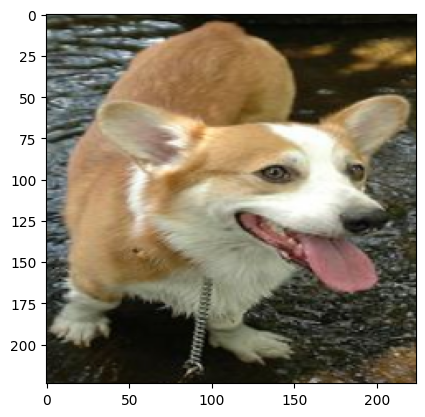

In [47]:
print("pred:", pred, "labels:", labels[rnd_idx])

images = images[rnd_idx].permute(1, 2, 0).cpu()
mean=torch.tensor([0.485, 0.456, 0.406]) 
std=torch.tensor([0.229, 0.224, 0.225])
images.mul_(std)
images.add_(mean)
print(images.shape)
plt.imshow(images)

In [48]:
def evaluation(model, testloader, loss_fn):
    total = 0   
    correct = 0
    test_loss = 0
    test_accuracy = 0

    with torch.no_grad():
        for batch in testloader:
            images, labels = batch['image'].to(device), batch['label'].to(device)

            logit = model(images)
            _, preds = torch.max(logit, 1)

            correct += int((preds == labels).sum())
            total += labels.shape[0]

            loss = loss_fn(logit, labels)
            test_loss += loss.item()
            
        test_accuracy = correct / total
   
        print('Test Loss : {:.3f}'.format(test_loss/len(testloader)), 
            'Test Accuracy : {:.3f}'.format(test_accuracy))


# 모델 저장

In [49]:
torch.save(model.state_dict(), 'last_ckpt_transfer_res101_batch16_default')

In [50]:
last_state_dict = torch.load('last_ckpt_transfer_res101_batch16_default')

In [51]:
last_model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
last_model.fc = nn.Linear(in_features=2048, out_features=120)
last_model.to(device)
last_model.get_parameter = last_model.load_state_dict(last_state_dict)

In [52]:
last_model.eval()
evaluation(last_model, testloader, loss_fn)  

Test Loss : 0.633 Test Accuracy : 0.835


In [56]:
best_state_dict = torch.load('best_ckpt_transfer_res101_batch16_default')

In [57]:
best_model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
best_model.fc = nn.Linear(in_features=2048, out_features=120)
best_model.to(device)
best_model.get_parameter = best_model.load_state_dict(best_state_dict)

In [58]:
best_model.eval()
evaluation(best_model, testloader, loss_fn)

Test Loss : 0.477 Test Accuracy : 0.861
